<a href="https://colab.research.google.com/github/tuhu02/proyekMachineLearning/blob/main/proyekML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Diabetes Menggunakan Metode Logistic Regression

## impor pustaka (library imports)

Memuat semua library (pustaka) yang diperlukan untuk proyek, termasuk Pandas untuk manipulasi data, Scikit-learn (sklearn) untuk Machine Learning dan preprocessing, serta Matplotlib dan Seaborn untuk visualisasi.  
warnings.filterwarnings('ignore') digunakan untuk menyembunyikan pesan peringatan agar output kode lebih rapi.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import kagglehub
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
                                                                                                                 vv vc   vv  vc
import matplotlib.pyplot as plt
import seaborn as sns

## Membaca (read) sebuah dataset diabetes_dataset.csv
Memuat data dari file CSV ke dalam DataFrame Pandas dan menyimpannya dalam variabel bernama df. DataFrame ini menjadi objek utama tempat semua analisis dan pemodelan dilakukan.

In [ ]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

## Menampilkan dimensi awal DataFrame.

In [ ]:
df.shape

(100000, 9)

## Menghitung total jumlah baris duplikat yang ada di dalam DataFrame df.

In [ ]:
df.duplicated().sum()

np.int64(3854)

## Menghapus semua baris duplikat yang ada di dalam DataFrame df.

In [ ]:
df = df.drop_duplicates()

## Memeriksa Dimensi baru DataFrame (Setelah Dihapus)

In [ ]:
df.shape

(96146, 9)

## Memverifikasi Duplikat
Memastikan bahwa tidak ada lagi baris duplikat yang tersisa dalam df.

In [ ]:
df.duplicated().sum()

np.int64(0)

## Statistik Deskriptif
Menghasilkan ringkasan statistik deskriptif (seperti rata-rata, deviasi standar, nilai minimum, dan kuartil) untuk semua kolom numerik dalam DataFrame.

In [ ]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


## Memeriksa Missing Value
Menghitung jumlah nilai yang hilang (missing values) untuk setiap kolom.

In [ ]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


Output semua 0 menunjukkan bahwa dataset ini sudah bersih dan tidak memerlukan penanganan missing value.

## Info Data dan Nilai Unik
* df.info(): Memberikan ringkasan teknis tentang DataFrame: jumlah baris,
jumlah kolom, Non-Null Count (untuk memastikan tidak ada missing value), dan tipe data (Dtype) setiap kolom.

* Kode berikutnya: Membuat DataFrame untuk merangkum tipe data dan jumlah nilai unik per kolom.

In [ ]:
df.info()
d = []
u = []
t = []
for col in df:
    d.append(col)
    u.append(df[col].nunique())
    t.append(df[col].dtype)
pd.DataFrame({'column':d,'type': t ,'unique value' : u})

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


,column,type,unique value
0,gender,object,3
1,age,float64,102
2,hypertension,int64,2
3,heart_disease,int64,2
4,smoking_history,object,6
5,bmi,float64,4247
6,HbA1c_level,float64,18
7,blood_glucose_level,int64,18
8,diabetes,int64,2


## Menghitung jumlah kemunculan setiap kategori dalam kolom gender.

In [ ]:
df['gender'].value_counts()

,count
gender,
Female,56161
Male,39967
Other,18


## Menghapus Kategori Other
Menghapus baris-baris di mana nilai gender adalah Other. Hal ini sering dilakukan karena jumlahnya yang terlalu kecil (18) sehingga tidak cukup mewakili untuk diikutkan dalam pemodelan (dapat menyebabkan noise atau kesalahan encoding).

In [ ]:
df = df[df['gender'] != 'Other']

## Memeriksa outlier atau anomali pada fitur-fitur numerik (age, bmi, HbA1c_level, blood_glucose_level) berdasarkan batasan nilai yang ditentukan (rules).

In [ ]:
rules = {
    'age': (0, 120),
    'bmi': (0, 80),
    'HbA1c_level': (0, 20),
    'blood_glucose_level': (0, 400)
}

issues = {
    f"{col}_below_min": (df[col] <= minv).sum()
    for col, (minv, maxv) in rules.items() if col in df.columns
}
issues.update({
    f"{col}_above_max": (df[col] > maxv).sum()
    for col, (minv, maxv) in rules.items() if col in df.columns
})

issues_df = pd.DataFrame(issues, columns=['Column', 'Below_Min', 'Above_Max', 'Total_Rows', 'Percent_Anomalies'])
display(issues_df.style.format({'Percent_Anomalies': '{:.4f}%'}))

,Column,Below_Min,Above_Max,Total_Rows,Percent_Anomalies


## Memperbarui statistik deskriptif setelah menghapus 18 baris gender = Other. Perubahan statistiknya sangat minim karena jumlah baris yang dihapus sangat kecil.

In [ ]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000
mean,41.796617,0.077615,0.040810,27.321450,5.532633,138.218001,0.088237
std,22.463329,0.267567,0.197851,6.767811,1.073225,40.911190,0.283640
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


## Menghitung jumlah kemunculan setiap kategori dalam kolom smoking_history.

In [ ]:
df['smoking_history'].value_counts()

,count
smoking_history,
never,34395
No Info,32881
former,9299
current,9197
not current,6359
ever,3997


## Mendefinisikan variabel Python untuk daftar kolom kategorikal yang akan diproses

In [ ]:
categorical_cols = ['gender', 'smoking_history']

## Melakukan One-Hot Encoding pada kolom kategorikal (gender dan smoking_history).
* pd.get_dummies() mengubah setiap nilai unik menjadi kolom biner (0 atau 1).
* drop_first=True menghindari multicollinearity dengan menghapus kolom pertama (misalnya, menghapus gender_Female jika gender_Male ada, atau smoking_history_No Info jika kategori ini mewakili data yang dihapus)

In [ ]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Memeriksa DataFrame yang Sudah Di-encode
Menampilkan 5 baris pertama dari DataFrame yang sudah di-encode.

In [ ]:
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,True,False,False,False,False


## Memeriksa Dimensi Setelah Encoding
Memeriksa dimensi lagi. Jumlah baris tetap 96.128 (setelah menghapus duplikat dan Other), dan jumlah kolom bertambah menjadi 13 karena kolom kategorikal dipecah menjadi beberapa kolom biner.

In [ ]:
df_encoded.shape

(96128, 13)

## Mendefinisikan variabel untuk daftar kolom numerik yang akan di-scale.

In [ ]:
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

## Melakukan Feature Scaling menggunakan StandardScaler.
* Ini menstandarisasi data numerik sehingga setiap kolom memiliki rata-rata
$\mu=0$ dan standar deviasi $\sigma=1$.
* Scaling sangat penting untuk model seperti Regresi Logistik dan K-NN agar semua fitur memberikan kontribusi yang setara, tanpa didominasi oleh fitur dengan rentang nilai yang lebih besar.

In [ ]:
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

## Menampilkan data yang telah di-scale.
Nilai pada kolom numerik (age, bmi, dll.) kini merupakan Z-Score (sudah distandarisasi).

In [ ]:
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.700709,0,1,-0.314941,0.994547,0.043558,0,False,False,False,False,True,False
1,0.543261,0,0,-0.000214,0.994547,-1.423041,0,False,False,False,False,False,False
2,-0.614187,0,0,-0.000214,0.155949,0.483538,0,True,False,False,False,True,False
3,-0.258049,0,0,-0.572042,-0.496294,0.410208,0,False,True,False,False,False,False
4,1.522640,1,1,-1.061124,-0.682649,0.410208,0,True,True,False,False,False,False


## Pemisahan Fitur dan Target
Mempersiapkan data untuk pelatihan model.
* Kolom target (diabetes) dipisahkan dan disimpan dalam variabel target.
* Kolom diabetes kemudian dihapus dari DataFrame fitur (df_encoded) karena ia adalah variabel yang akan diprediksi.

In [ ]:
target = df_encoded['diabetes']
df_encoded.drop('diabetes', axis=1, inplace=True)

Membagi data yang sudah disiapkan menjadi set pelatihan (train) dan set pengujian (test).
* test_size=0.2: 20% data digunakan untuk pengujian, 80% untuk pelatihan.
* random_state=42: Memastikan pembagian data konsisten (dapat direproduksi).
* stratify=target: Memastikan distribusi kelas target (diabetes) sama di kedua set (penting untuk data yang tidak seimbang).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.2, random_state=42, stratify=target)

## Melatih model Regresi Logistik.
* Membuat instance model (lg).
* lg.fit(): Melatih model menggunakan data pelatihan (X_train, y_train).

In [ ]:
lg = LogisticRegression(max_iter=1000, random_state=42)
lg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Menggunakan model lg yang sudah dilatih untuk membuat prediksi pada data pengujian (X_test). Hasil prediksi disimpan di y_pred_lg.

In [ ]:
y_pred_lg = lg.predict(X_test)

## Evaluasi Logistic Regression:
* Confusion Matrix: Menghitung matriks kebingungan dan memvisualisasikannya sebagai heatmap untuk melihat jumlah True Positives, False Positives, dll.
* Metrik: Menghitung dan mencetak metrik utama: Accuracy, Precision, Recall, dan F1-Score.

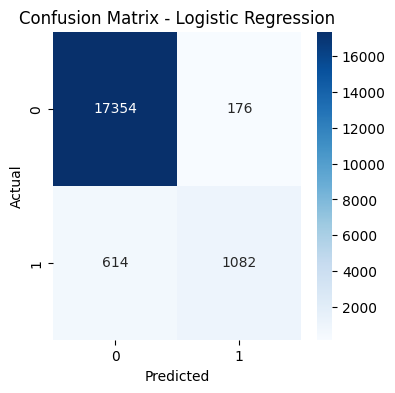

Accuracy:  0.9589
Precision: 0.8601
Recall:    0.6380
F1-Score:  0.7326


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lg)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Metrics
accuracy = accuracy_score(y_test, y_pred_lg)
precision = precision_score(y_test, y_pred_lg)
recall = recall_score(y_test, y_pred_lg)
f1 = f1_score(y_test, y_pred_lg)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')

## Melatih model K-Nearest Neighbors (K-NN).
* Membuat instance model (knn) dengan $k=7$ (jumlah tetangga).
* knn.fit(): Melatih model menggunakan data pelatihan.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

## Menggunakan model knn yang sudah dilatih untuk membuat prediksi pada data pengujian (X_test).

In [ ]:
y_pred_knn = knn.predict(X_test)

## Evaluasi K-NN
* Confusion Matrix: Menghitung dan memvisualisasikan matriks kebingungan.
* Metrik: Menghitung dan mencetak Accuracy, Precision, Recall, dan F1-Score.

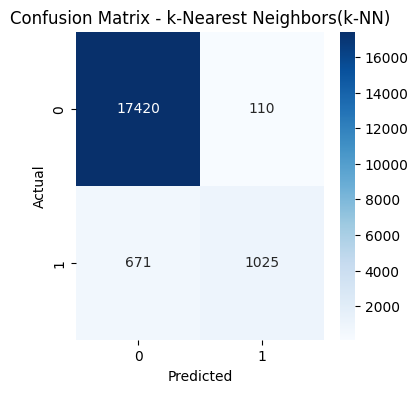

Accuracy:  0.9594
Precision: 0.9031
Recall:    0.6044
F1-Score:  0.7241


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - k-Nearest Neighbors(k-NN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Metrics
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')